Malware Opcode Classification 

Authored by David Luong

Reference: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # for plotting model loss

#Import svm model
from sklearn import svm
#Import random forest model
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

#Import knn model
from sklearn.neighbors import KNeighborsClassifier

# Final evaluation of the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score
from sklearn.naive_bayes import GaussianNB

# fix random seed for reproducibility
tf.random.set_seed(7)

import os
import sys
import json

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Define Run Settings

In [9]:
# parameters
real_malware = 'WinWebSec' # OnLineGames, Renos, VBInject, WinWebSec, Zbot, Mixed

use_harshit = 0 # 1 to use Harshit's fake samples, other to use Albert's
select_malware = 'vae_cnn_samples' # wgan_gp_samples, vae_cnn_samples, vae_dense_samples
select_vectorization = 'pos' # freq, pos
unique_opcodes = 1 # 0 = visualize_explore/opcodes, 1 = fake_tests/opdicts
max_sequence_length = 600
use_deep_classifiers = 0 # 1+ = use, 0 do not use 
target_names = ['Real', 'Fake']

# LSTM
embedding_vector_length = 32

if real_malware == 'WinWebSec':
    fake_malware = 'wws'
    top_opcodes = 22
elif real_malware == 'OnLineGames':
    fake_malware = 'olgames'
    top_opcodes = 22
elif real_malware == 'Renos':
    fake_malware = 'renos'
    top_opcodes = 22
elif real_malware == 'VBInject':
    fake_malware = 'vbinject'
    top_opcodes = 25
elif real_malware == 'Zbot':
    fake_malware = 'zbot'
    top_opcodes = 20
elif real_malware == 'Mixed':
    fake_malware = 'mixed'
    top_opcodes = 41
else:
    print('!!!Malware not found!!!')


Define Helper Functions

In [10]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# Python code to count the number of occurrences
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

# opcodes are indexed by overall frequency
def get_opcode_freq(opcode_frequency):
    rank = 0
    prev_count = -1
    for item in sorted(opcode_frequency,reverse=True):
        # increment rank if current opcode has different frequency than previous opcode
        if prev_count != item[0]:
            rank+=1
        # assign frequency rank
        opcode_frequency[item[1]] = rank
        # save previous frequency
        prev_count = item[0]
    return opcode_frequency

# opcodes are indexed by unique opcode position (opcodes_into_list)
def get_opcode_pos(data_into_list,opcodes_into_list):
    opcode_position = []
    nx = 0
    for x in data_into_list:
        ny = 0
        for y in opcodes_into_list:
            if x == y:
                opcode_position.append(ny)
                break
            ny+=1
        nx+=1
        # index for unknown opcodes
        if len(opcodes_into_list) == ny:
            opcode_position.append(ny)
    return opcode_position

# get opcode list from opdict
def get_opcode_dict(malware_fam,file_path):
    my_opcodes = file_path + 'opdict' + malware_fam + '.json'
    with open(my_opcodes) as json_file:
        data = json.load(json_file)
    return list(data.keys())

Load Real and Fake Malware Files

In [11]:
# initialize variables
dataset = []
dataset_names = []
dataset_ind = []

# opening list of unique opcodes
if unique_opcodes == 0:
    my_fp = './code/visualize_explore/opcodes/'
    my_opcodes = open(my_fp + 'opcodes' + real_malware + '.txt','r')
    opcodes = my_opcodes.read()
    opcodes_into_list = opcodes.replace('\n', ' ').split(" ")
    opcodes_into_list.remove('')
    # close opcodes file
    my_opcodes.close()
elif unique_opcodes == 1:
    my_fp = main_dir + '/code-20230116T073801Z-001/code/fake_tests/opdicts/'
    opcodes_into_list = get_opcode_dict(real_malware,my_fp)

# real malware parameters
my_filepath = "../malware_data/" + real_malware +'/'
dir_list = os.listdir(my_filepath)

# process real malware
for fm in dir_list:
    # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
    print('Processing real malware' + my_filepath + fm)

    # opening the file in read mode
    my_file = open(my_filepath + fm, "r")

    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.replace('\n', ' ').split(" ")

    # remove '' from opcodes
    data_into_list.remove('')

    opcode_frequency = []
    if data_into_list:
            
        # create (opcode frequency, rank) tuple
        idx = 0
        for x in opcodes_into_list:
            count = countX(data_into_list, x)
            #print('{} has occurred {} times'.format(x,count))
            opcode_frequency.append((count,idx))
            idx+=1
        # print(sorted(opcode_frequency,reverse=True))

        # opcodes are indexed by overall frequency
        opcode_frequency = get_opcode_freq(opcode_frequency)

        # opcodes are indexed by opcodes_into_list position
        opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

        # add real malware to dataset
        dataset.append(opcode_position)
        dataset_names.append(fm)
        dataset_ind.append(0) # 0 is indicator for real malware
    else:
        # skip processing if malware file is empty
        print('------------> is empty ... skipping')

    # close file
    my_file.close()

nRealSamples = len(dataset)

# create fake malware dataset
if use_harshit == 1:
    my_fake_filepath = './code/fake_tests/fakeSamples_small/' + fake_malware # Harshit
    dir_list_fake = os.listdir(my_fake_filepath)

    for fake in dir_list_fake:
        print('Processing Harshit\'s fake malware' + my_fake_filepath + '/' + fake)

        # open the file
        my_fake_opcodes = open(my_fake_filepath + '/' + fake, "r")

        # reading the file
        data = my_fake_opcodes.read()

        # replacing end of line('/n') with ' ' and
        # splitting the text it further when '.' is seen.
        data_into_list = data.replace('\n', ' ').split(" ")

        # remove '' from opcodes
        data_into_list.remove('')

        opcode_frequency = []
        if data_into_list:
                
            # create (opcode frequency, rank) tuple
            idx = 0
            for x in opcodes_into_list:
                count = countX(data_into_list, x)
                #print('{} has occurred {} times'.format(x,count))
                opcode_frequency.append((count,idx))
                idx+=1
            # print(sorted(opcode_frequency,reverse=True))

            # opcodes are indexed by overall frequency
            opcode_frequency = get_opcode_freq(opcode_frequency)

            # add real malware to dataset
            if select_vectorization == 'freq':
                dataset.append(opcode_frequency)
            elif select_vectorization == 'pos':
                opcode_list = []
                for oc in data_into_list:
                    opcode_list.append(int(oc))
                dataset.append(opcode_list)

            dataset_names.append(fake)
            dataset_ind.append(1)

        # close opcodes file
        my_fake_opcodes.close()

else: # self-generated malware
    
    # fake malware parameters
    my_fake_filepath = './code/fake_tests/' + select_malware + '/' + fake_malware + '/'
    dir_list = os.listdir(my_fake_filepath)

    # process fake malware
    for fm in dir_list:
        # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
        print('Processing fake malware' + my_fake_filepath + fm)

        # opening the file in read mode
        my_fake_file = open(my_fake_filepath + fm, "r")

        # reading the file
        data = my_fake_file.read()

        # replacing end of line('/n') with ' ' and
        # splitting the text it further when '.' is seen.
        data_into_list = data.replace('\n', ' ').split(" ")

        # remove '' from opcodes
        data_into_list.remove('')

        opcode_frequency = []
        if data_into_list:
                
            # create (opcode frequency, rank) tuple
            idx = 0
            for x in opcodes_into_list:
                count = countX(data_into_list, x)
                #print('{} has occurred {} times'.format(x,count))
                opcode_frequency.append((count,idx))
                idx+=1
            # print(sorted(opcode_frequency,reverse=True))

            # opcodes are indexed by overall frequency
            opcode_frequency = get_opcode_freq(opcode_frequency)

            # opcodes are indexed by opcodes_into_list position
            opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

            # add fake malware to dataset
            if select_vectorization == 'freq':
                dataset.append(opcode_frequency)
            elif select_vectorization == 'pos':
                opcode_list = []
                for oc in data_into_list:
                    opcode_list.append(int(oc))
                dataset.append(opcode_list)

            dataset_names.append(fm)
            dataset_ind.append(1) # 1 is indicator for fake malware
        else:
            # skip processing if malware file is empty
            print('------------> is empty ... skipping')

        # close file
        my_fake_file.close()

nFakeSamples = len(dataset) - nRealSamples

# convert dataset to numpy arrays
X = np.array(dataset,dtype=object)
y = np.array(dataset_ind,dtype='int64')

# print
nSamples = len(X)
print('There are', nSamples, 'malware files')

Processing real malware../malware_data/WinWebSec/0d424ab66081e9562b4a1136d5fc1de7f6b27a90.asm.txt
Processing real malware../malware_data/WinWebSec/114e7b5acd7894eba0ffa6d7d7b7edd2058c50d4.asm.txt
Processing real malware../malware_data/WinWebSec/551369dafcb66d1f1137631c32e57c54422dcfed.asm.txt
Processing real malware../malware_data/WinWebSec/760ff1f98508c4efb2b3db9f3392ba6c154ca253.asm.txt
Processing real malware../malware_data/WinWebSec/1fdcdb634aae85a9682a5c49372b16846fe16a88.asm.txt
Processing real malware../malware_data/WinWebSec/3dc2c9b89dd4a376826dd28c925d01fdf92e771b.asm.txt
Processing real malware../malware_data/WinWebSec/f69a22a8f2d3988575ba79f7283a6a9968f4935e.asm.txt
Processing real malware../malware_data/WinWebSec/4654b6dc03b8426e07517972b1f66f84717a151e.asm.txt
Processing real malware../malware_data/WinWebSec/66072ec2439a874a114d93f13eef785a7fc231f7.asm.txt
Processing real malware../malware_data/WinWebSec/aa9e31cc0387df312b81b76738604115e03ed83d.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/21eaa5005dec0ce1923123a0ea2dcd756b0eea3c.asm.txt
Processing real malware../malware_data/WinWebSec/0e38f2a9b3fa2ac2958e1819edc9c220bfb4200a.asm.txt
Processing real malware../malware_data/WinWebSec/fd95c0dc4aa5849ef4f0cc8b07b169c5ace654a2.asm.txt
Processing real malware../malware_data/WinWebSec/0641da7d7f6c6d8ba6c893436d9d2bdeda06b8af.asm.txt
Processing real malware../malware_data/WinWebSec/129e82a92b880418c246e00163695d87408f5d85.asm.txt
Processing real malware../malware_data/WinWebSec/e98ab2bf9f2eff49dee2e07c13015576641516a1.asm.txt
Processing real malware../malware_data/WinWebSec/d567bc4c546aa08e8f5aa4e8eb2cf645450a107b.asm.txt
Processing real malware../malware_data/WinWebSec/66ab60979ff267ab4692e9afa6bf10156eafbc12.asm.txt
Processing real malware../malware_data/WinWebSec/8540aa443bc5ad3d083d9f0d15b39614ff633e0e.asm.txt
Processing real malware../malware_data/WinWebSec/36fa7c824aec2e8965e1414280229833b8c9a6b1.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/e5d84338b66f02dab6787e605fd70d1f0e6fae90.asm.txt
Processing real malware../malware_data/WinWebSec/ef22dde5aae9709548bf59aac3b0f1e3009ba9f3.asm.txt
Processing real malware../malware_data/WinWebSec/f61d33201ab9d62789c4dd8131566201bc5ae4ff.asm.txt
Processing real malware../malware_data/WinWebSec/2b3160b75c000013f16a89861fe6405b193c55a6.asm.txt
Processing real malware../malware_data/WinWebSec/a7b674086701a15b08aa91c722b4575937acf59d.asm.txt
Processing real malware../malware_data/WinWebSec/7a07d9e34e5e1ce635c610b8b48ff617cf84519e.asm.txt
Processing real malware../malware_data/WinWebSec/d0a0552cd000d994ac276b61d63b014ac35dc95e.asm.txt
Processing real malware../malware_data/WinWebSec/d7271a513496bacf931c3078fd79ca51be16b18b.asm.txt
Processing real malware../malware_data/WinWebSec/9fc5f23dc66a7d66a762472fbf4ad0bdacae8f66.asm.txt
Processing real malware../malware_data/WinWebSec/e3c7710ede1c9eae9f3bdc575e95d239d1f941b1.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/a02d8405abe9dc837cdcb2e99c830570f94d750f.asm.txt
Processing real malware../malware_data/WinWebSec/0b738a6d030d801133133938c83e3a4518cb0f04.asm.txt
Processing real malware../malware_data/WinWebSec/62d74895729251cdf5c3b88a9cc235e6db662600.asm.txt
Processing real malware../malware_data/WinWebSec/3826035ec7823565e68c0cedcf599243201d55db.asm.txt
Processing real malware../malware_data/WinWebSec/5cf6834237d329cc89851ee2cf9fa3c52cdb712c.asm.txt
Processing real malware../malware_data/WinWebSec/f9e6919840e6d13a9db3c54c5568ddf12471c453.asm.txt
Processing real malware../malware_data/WinWebSec/d754558fb875492e6903554217ae13d6db0a0537.asm.txt
Processing real malware../malware_data/WinWebSec/9a34c850a5206efe5f3783770186c265466fe9ae.asm.txt
Processing real malware../malware_data/WinWebSec/769af7489500ca387627e2ac7c2f3793a77fd454.asm.txt
Processing real malware../malware_data/WinWebSec/93cb62c8d414c4c657d494d55885a3b70308c357.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/44dcb6e3deda87e4b15c331776b6a42154d0a59e.asm.txt
Processing real malware../malware_data/WinWebSec/37a7a14f59e1cffcbe9e320a58de7820f793efc8.asm.txt
Processing real malware../malware_data/WinWebSec/84f85dab5d7bf70afa2d22c5d5f17a8f419c0571.asm.txt
Processing real malware../malware_data/WinWebSec/dd4deb1a956de7c81782d45bfec07108aab8eb4d.asm.txt
Processing real malware../malware_data/WinWebSec/95bd88923f71f818b953a492a34eb8c5b117693a.asm.txt
Processing real malware../malware_data/WinWebSec/8767dab3e117ece2d22c8bd6c656fdf5468e0e5a.asm.txt
Processing real malware../malware_data/WinWebSec/fb81e6047a207367620ed0ac50bb36c5be7e18a8.asm.txt
Processing real malware../malware_data/WinWebSec/51c40ea308b769ec9c094d6488d7031e067468a2.asm.txt
Processing real malware../malware_data/WinWebSec/1c8a9239f0b09c0cf909e3c0054d85ece3a4dd2b.asm.txt
Processing real malware../malware_data/WinWebSec/16ee81578fb6084974c53473410cd9a4be73eccf.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/bd3ba55fffd47c09f9a30caa50d2bb0c5b356596.asm.txt
Processing real malware../malware_data/WinWebSec/60e6822489c5fab9c6d52da6ad0d5f222634abea.asm.txt
Processing real malware../malware_data/WinWebSec/0825a5e9a12f0bd29466443ba05ab6e2095860bf.asm.txt
Processing real malware../malware_data/WinWebSec/c3a4ed13a7bb3f92335f28bc7472ee759c634efa.asm.txt
Processing real malware../malware_data/WinWebSec/39644ef6924e4acf9f0a26069cc3acde02765f9e.asm.txt
Processing real malware../malware_data/WinWebSec/9a7289bb2017444420a7ab90709bad86e2e58cec.asm.txt
Processing real malware../malware_data/WinWebSec/b4c1e4bc51897a7dbda34e256ecc02586bab60c8.asm.txt
Processing real malware../malware_data/WinWebSec/f731a4362db8d50f488aa57530f4eb4813655201.asm.txt
Processing real malware../malware_data/WinWebSec/308677e8551d094ad494da7e455f113d4c7217b7.asm.txt
Processing real malware../malware_data/WinWebSec/722636014393704d271ddd5c374076d0b9c1f02b.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/e318545d89bab0caba20f6526a491f3951a5d011.asm.txt
Processing real malware../malware_data/WinWebSec/766710fcd4df32aa7040a5ddfec2943780a671ec.asm.txt
Processing real malware../malware_data/WinWebSec/cdd63d3434dea7813db111b6dd4a0a0ad9d34079.asm.txt
Processing real malware../malware_data/WinWebSec/46caefeeae04dadf9b03e89b518d22c4d113a5a4.asm.txt
Processing real malware../malware_data/WinWebSec/0c3fbf08dc27b5e7618e63789894dd0a12e8bb19.asm.txt
Processing real malware../malware_data/WinWebSec/7c4c6830a8fbb7d41e5ff4308e3d70a1a4c32aa4.asm.txt
Processing real malware../malware_data/WinWebSec/b31c9f15419d767ce771169612c1cabeb03e0264.asm.txt
Processing real malware../malware_data/WinWebSec/83c45e8d10777ac695bb6de736b0d09af0b1be58.asm.txt
Processing real malware../malware_data/WinWebSec/1ab9a7ec383d64087b10de2ac021e00f41b53d34.asm.txt
Processing real malware../malware_data/WinWebSec/fb0d314b040499b4ae1ff917ffc53a002353266c.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/08ed56c120b2e1dd1844f81f5e27d5d9f0161f54.asm.txt
Processing real malware../malware_data/WinWebSec/cd9b81df14d7fd5ba8446ea40e49c00371141b95.asm.txt
Processing real malware../malware_data/WinWebSec/1ef478ab76122afd10f40202d109eae83cb37312.asm.txt
Processing real malware../malware_data/WinWebSec/de4043d8e486929eb4c4f3102d0714f98b138111.asm.txt
Processing real malware../malware_data/WinWebSec/5c3d20a3b93dcd595032ee070f44966cdf58bd6c.asm.txt
Processing real malware../malware_data/WinWebSec/ba3d97c076412ea6863fb6cc6865e63f5c034a86.asm.txt
Processing real malware../malware_data/WinWebSec/8bd591fc6a473651e1b27cb5d964ed181abd1a27.asm.txt
Processing real malware../malware_data/WinWebSec/4cea1ae3fe44a9587264b907dda6c1a7d7ed2130.asm.txt
Processing real malware../malware_data/WinWebSec/e36a397e81e819e3b3990be15f3b59ee733b88f4.asm.txt
Processing real malware../malware_data/WinWebSec/14c9862f8ed46b51e3e6ac02c5dbac1bdd0cca06.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/740e313af9b676885c7ca5d88f3fda2a4d735cd0.asm.txt
Processing real malware../malware_data/WinWebSec/c05e88c9bf5f40f85aadb4645c9bc80ec87c45fc.asm.txt
Processing real malware../malware_data/WinWebSec/777b1d49038488fa364e8abc18979751e5d0e57e.asm.txt
Processing real malware../malware_data/WinWebSec/968d40cfd96e0d3af60cf0a4dd81fe772d7ddf35.asm.txt
Processing real malware../malware_data/WinWebSec/5b8c741b080f47f29d5f299852cde9429f3cb6d8.asm.txt
Processing real malware../malware_data/WinWebSec/daf411d4e8197fe3dc8799c84968a6e370902b3f.asm.txt
Processing real malware../malware_data/WinWebSec/2d4888b3cb1bda2521da83b3126743b7c9ab6765.asm.txt
Processing real malware../malware_data/WinWebSec/9471baab7972935eaceeac6c8c39ae25083cf7d4.asm.txt
Processing real malware../malware_data/WinWebSec/d682cd92e9de003ed89b1995cbb40bf1ee329e10.asm.txt
Processing real malware../malware_data/WinWebSec/afa30f1fe572ff47cd1e9195df1221bd999b7737.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/11269a83cc0c1a533e08e3d14686b5f299b5c841.asm.txt
Processing real malware../malware_data/WinWebSec/19ba946f3910a923218f342897a9b4a400aaa6c8.asm.txt
Processing real malware../malware_data/WinWebSec/9688399b565877a4e13374e4e4242e589eff105a.asm.txt
Processing real malware../malware_data/WinWebSec/5e661b601f4b3c1f4c1440a4e1df0964b6ebb89e.asm.txt
Processing real malware../malware_data/WinWebSec/289b82fdc1ff5811f68d45e48509a1947bd2398e.asm.txt
Processing real malware../malware_data/WinWebSec/7a3701c02676fd2daadd6e7e7046147bba6dd141.asm.txt
Processing real malware../malware_data/WinWebSec/1bc25fb5f0d5dbb8c1602171e73180a117b0e20d.asm.txt
Processing real malware../malware_data/WinWebSec/1c45858b2a1cf101ee2dbc25ece21a26a4d16f5b.asm.txt
Processing real malware../malware_data/WinWebSec/2af2223936fb8a192741a98c5063dca1c7178852.asm.txt
Processing real malware../malware_data/WinWebSec/35d45aecc24e01aca91c2ae8bc1b19c2091202f6.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/20d9e95f7651fe1de82b2b5f1fb3dad4f06c55a5.asm.txt
Processing real malware../malware_data/WinWebSec/6e66f7bb006946a6f23b6a47969b94863f8db2ba.asm.txt
Processing real malware../malware_data/WinWebSec/1c28e2f695658327ad5d8576e3e542e43fa3dd97.asm.txt
Processing real malware../malware_data/WinWebSec/b6cdfcc8106de6fa3a21a4ca135416ab49f8302e.asm.txt
Processing real malware../malware_data/WinWebSec/5718e210172669365af21e9a0c64fe724f15c1af.asm.txt
Processing real malware../malware_data/WinWebSec/0f19704681afb01502bb057bbe1c29b76febbce8.asm.txt
Processing real malware../malware_data/WinWebSec/c2f5395095f6e7a355ea7292552846ce15155d96.asm.txt
Processing real malware../malware_data/WinWebSec/36bef04c495490ee30bf496ef9de3b7c12b75005.asm.txt
Processing real malware../malware_data/WinWebSec/732579cd1e8ad8d38ea3a087ac613f7a6b8b89d6.asm.txt
Processing real malware../malware_data/WinWebSec/777efa1028826dfa185855548102cf14bcac4ebd.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/99241a88015c478b0c9b6aec8110601a48a5a57f.asm.txt
Processing real malware../malware_data/WinWebSec/db42ebc719744412e4017b674d7dfc055ff6dd65.asm.txt
Processing real malware../malware_data/WinWebSec/16abc4f13f05efc48af66ad930f9ec33ac865fbc.asm.txt
Processing real malware../malware_data/WinWebSec/200e77b8fd554409f422a0bff97736b8bdaa211c.asm.txt
Processing real malware../malware_data/WinWebSec/bb311c6cb05319d7b92b92da543187904d838fea.asm.txt
Processing real malware../malware_data/WinWebSec/909966831ae776d71c18b03356a87c4d8e05daa1.asm.txt
Processing real malware../malware_data/WinWebSec/4fbb1f39e1ba9505dee984057f4ffa386d63b903.asm.txt
Processing real malware../malware_data/WinWebSec/feb0059f3b5d6421d32ae8170fe070e71e8b54f0.asm.txt
Processing real malware../malware_data/WinWebSec/e28b6828f78cc8d161debc66923020150c8aba35.asm.txt
Processing real malware../malware_data/WinWebSec/c0b4ab6eda97fbb98beb64e10e9a44f65689f934.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/f855273204fba5311d0fc002c9202be1afbd3f79.asm.txt
Processing real malware../malware_data/WinWebSec/196794755bd13dc5b316a4e266a3cc41d3fb7fd0.asm.txt
Processing real malware../malware_data/WinWebSec/fa9fc4cb5f754848d6348025a1306f44ff041a7e.asm.txt
Processing real malware../malware_data/WinWebSec/fdc9d28a43c4e911f5f01038e7b37932bd3eb7a9.asm.txt
Processing real malware../malware_data/WinWebSec/54faef4c20ee96a10d5c13764c4c5f9c1bd57494.asm.txt
Processing real malware../malware_data/WinWebSec/c8c9a454fd7f5f49ff6558d79a58e56ad90ce484.asm.txt
Processing real malware../malware_data/WinWebSec/a018932c22d17ac8325765acdf62420e9a3c5f85.asm.txt
Processing real malware../malware_data/WinWebSec/fd4fb09ec3077418453d59a232c08c2f0801c253.asm.txt
Processing real malware../malware_data/WinWebSec/f657ffa7b0963b15ee13a24178654fe7cafd52c6.asm.txt
Processing real malware../malware_data/WinWebSec/76f776ebe63a09151c02f289c0fc8c9da25f6fc8.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/44e0b01c7d59bde1830c8d9b02eb81226ff9f521.asm.txt
Processing real malware../malware_data/WinWebSec/2d4f8da9ddd757fbc87d787e71fed25a4bf5fd27.asm.txt
Processing real malware../malware_data/WinWebSec/07434259a691dafff5ecbac29ae6daaca934bde5.asm.txt
Processing real malware../malware_data/WinWebSec/61665bbf2cd9bcd9d6041f443bed38339c6bcd78.asm.txt
Processing real malware../malware_data/WinWebSec/11e379d135cb15a9c38152ced82e8f71a78275f0.asm.txt
Processing real malware../malware_data/WinWebSec/a5aa3dad4a13e81b2c5cbe4ad974f9b396ef3a50.asm.txt
Processing real malware../malware_data/WinWebSec/5e7e1481f099db18dab6c1a74d91ce86b55aaa81.asm.txt
Processing real malware../malware_data/WinWebSec/667493309346f81c2c22132aa2bdb218f2efdc6a.asm.txt
Processing real malware../malware_data/WinWebSec/5bacd1e77e037f085c8e1bbfc0b4591e5aa9e195.asm.txt
Processing real malware../malware_data/WinWebSec/c2f0135d69d07d76fce24318bdfb21e133967fa7.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/992d1c9dca1d010894f24625827f2230644cf440.asm.txt
Processing real malware../malware_data/WinWebSec/6d938f14fee146d72d84cba1d2afc4e92b44b2d5.asm.txt
Processing real malware../malware_data/WinWebSec/d005189aae7d5c85c7f376f83c3ddf5d792e59f6.asm.txt
Processing real malware../malware_data/WinWebSec/e567550874ec118989621dc4456c97c4f745f99e.asm.txt
Processing real malware../malware_data/WinWebSec/dd4d08a5c2df343da9d96ef3db5f5574e21911c5.asm.txt
Processing real malware../malware_data/WinWebSec/edaa67e05f63a1a7c72142961a24aa1deecbfe77.asm.txt
Processing real malware../malware_data/WinWebSec/9a6be48e74513b73fe1afdb902e9e74f5b95dcfc.asm.txt
Processing real malware../malware_data/WinWebSec/5e18bfed4b8c608aa5f18563138c085c8487b1b2.asm.txt
Processing real malware../malware_data/WinWebSec/3a6e2224114da18b89c16e2f8806588a8309da46.asm.txt
Processing real malware../malware_data/WinWebSec/0d2bf6be3059b2789525f7fac78b0ab0ddbf093f.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/9aea40dd50b1748ab410931d783ac2c3ad401c4a.asm.txt
Processing real malware../malware_data/WinWebSec/7165f678986e12bc80ef8a747abf2b5ef0bfb898.asm.txt
Processing real malware../malware_data/WinWebSec/51a5a4fe86d4cc4567ee84dd0502088869ee5236.asm.txt
Processing real malware../malware_data/WinWebSec/0ad86c27ba8373b24d9093450265b77a29c9fc30.asm.txt
Processing real malware../malware_data/WinWebSec/754aeb757ac9b180c2132fa5668d4ce30b2c94c3.asm.txt
Processing real malware../malware_data/WinWebSec/c9bcec7ce6c5d679f0c39a01a166f24a1982801f.asm.txt
Processing real malware../malware_data/WinWebSec/b931723a403e70acf91911642c922d5031a305a3.asm.txt
Processing real malware../malware_data/WinWebSec/a49cdc8cc483850317e50106909064a7c0d81483.asm.txt
Processing real malware../malware_data/WinWebSec/e308d3068dd8f0f4dd7dd98473323e528f6a70f7.asm.txt
Processing real malware../malware_data/WinWebSec/4f5cff2d800ab9832943614b9422c99b4aef66e6.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/a3703f7b672a92736e6c4e5a3b986ac761955b6c.asm.txt
Processing real malware../malware_data/WinWebSec/cd67077bd439eeec60d9c1fb78df7818b920127b.asm.txt
Processing real malware../malware_data/WinWebSec/88d5def3b1fb887feda66b98def97d25e7eeaa4e.asm.txt
Processing real malware../malware_data/WinWebSec/976040e5b01f1a95e9a9fc6867dd010d18453ca1.asm.txt
Processing real malware../malware_data/WinWebSec/e897c7bb82306f530ddfc5d88f4c5a6860e493fe.asm.txt
Processing real malware../malware_data/WinWebSec/9779fe744f8887a9626d4a2fe2e2ed8b7f9c0241.asm.txt
Processing real malware../malware_data/WinWebSec/08876dded0a9115de254243ff71d1cbde60aeefa.asm.txt
Processing real malware../malware_data/WinWebSec/cf11e7b7bce3a901976d3c77175d724bbf684373.asm.txt
Processing real malware../malware_data/WinWebSec/0354229aadae0a004051c587010a37ba5e766e4b.asm.txt
Processing real malware../malware_data/WinWebSec/d39d511789ed6f98ba7ba0eaa51dcbe44a79b800.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/19c2c66e087454ba6a1fc707c1a4dfc7821e0bb2.asm.txt
Processing real malware../malware_data/WinWebSec/e2b7e36e91f4dbf3ecc040bbd6e812a785e32c91.asm.txt
Processing real malware../malware_data/WinWebSec/7ef98eb7233e296e1ea58586e93943a59108f09f.asm.txt
Processing real malware../malware_data/WinWebSec/c43baf5893cba44ebbf66a667dc310ccc9cd6edb.asm.txt
Processing real malware../malware_data/WinWebSec/24d8947195a9d6c30a25c787ecf2160e3212ed8d.asm.txt
Processing real malware../malware_data/WinWebSec/78b8a33421c7bffb57e99c1ca1d07d40ac508a74.asm.txt
Processing real malware../malware_data/WinWebSec/dc9ba5f476026f7fa5cc5bac3439d20a7e037f87.asm.txt
Processing real malware../malware_data/WinWebSec/5fd69fa9962bbbb278c711ea736cdd49c09874b7.asm.txt
Processing real malware../malware_data/WinWebSec/5bd99a06001088b7766df84f9cd335c02ed134d1.asm.txt
Processing real malware../malware_data/WinWebSec/f3f685167628e71bef0f24020599bbcc09496b4d.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/2f6eb4f746c5283ad8e4abc6251fdde145bdf8a5.asm.txt
Processing real malware../malware_data/WinWebSec/35996ff3592e294c900fa4778a83d1d30600a00a.asm.txt
Processing real malware../malware_data/WinWebSec/a1155d6f3730f02d8e5adeed1fb3ea0c4b790930.asm.txt
Processing real malware../malware_data/WinWebSec/058d9bf6f5d251b207bf3b9a33d02356e6bc2ae9.asm.txt
Processing real malware../malware_data/WinWebSec/3fb9a84c59ec1849b3c359c52bd5d387fd87337b.asm.txt
Processing real malware../malware_data/WinWebSec/2e1f276bafba1aba620390ac7a9b7eeda81b2c6f.asm.txt
Processing real malware../malware_data/WinWebSec/3d159fc821d462a6224e6532e9bb41b1de7d8587.asm.txt
Processing real malware../malware_data/WinWebSec/7048accb305edc46d6193e4676fea578214c5fcb.asm.txt
Processing real malware../malware_data/WinWebSec/eee78d7905200b7cec74144c740477880754c3e5.asm.txt
Processing real malware../malware_data/WinWebSec/926be095a438d261326fefb6007dc069eabe9def.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/7b96d458157aad16f60094bbfc8aa545bcb103b9.asm.txt
Processing real malware../malware_data/WinWebSec/6a68dd23788ff87d00b9fd4122bd3f8fe02861b5.asm.txt
Processing real malware../malware_data/WinWebSec/21646606dcfc477a4fa16d1a47e00f28bf3c37f7.asm.txt
Processing real malware../malware_data/WinWebSec/8175538e50e8c01913c6a31ed8d248da43664341.asm.txt
Processing real malware../malware_data/WinWebSec/65bc453e6657fb112c3b219df04a0b6e9c1415f6.asm.txt
Processing real malware../malware_data/WinWebSec/f68c9a99b859110bddab5a147acc177081cd0312.asm.txt
Processing real malware../malware_data/WinWebSec/e32874725179c827142dbcc1d9dee774be01b1a5.asm.txt
Processing real malware../malware_data/WinWebSec/0e05b4f21c489493576a84d37af7d723474bfa8c.asm.txt
Processing real malware../malware_data/WinWebSec/f886f4ce4ba0d20edf70dbfc306de3ee0263608a.asm.txt
Processing real malware../malware_data/WinWebSec/186f713286321bdba56fda0355a7b58b5ca4378f.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/2b888047cf18633ef9d177b7f46df08738595f0d.asm.txt
Processing real malware../malware_data/WinWebSec/2038735f92ecfac72f496799a96d18ca4e71ebde.asm.txt
Processing real malware../malware_data/WinWebSec/68e56a1f6f4329331a5e7b646f809bcdab33bac9.asm.txt
Processing real malware../malware_data/WinWebSec/9829bf743e078f192835b4dd396955b7cc115711.asm.txt
Processing real malware../malware_data/WinWebSec/b876e0c3dba9db39db65decb92dd8ba5677cce37.asm.txt
Processing real malware../malware_data/WinWebSec/b0a3ee214c07da3af2a1f505c2daa8f10f3e74a6.asm.txt
Processing real malware../malware_data/WinWebSec/f00b2959006de8c5df3088073097d1e35f6820e1.asm.txt
Processing real malware../malware_data/WinWebSec/5bc2be1a8f1e0b6a985e21fe9d004a9bcfa8a279.asm.txt
Processing real malware../malware_data/WinWebSec/b98ca9d31a4728ef0092ac5299a6744dd1a26fff.asm.txt
Processing real malware../malware_data/WinWebSec/9016321dd283f0badc2e6ed372e0b6c3bbf76c4f.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/77a2856322644d8f4072fd8c3aa44e5666121f20.asm.txt
Processing real malware../malware_data/WinWebSec/369221f55b9d7ca988e93d508bdf73e98926aa73.asm.txt
Processing real malware../malware_data/WinWebSec/c892a5a7baaff4d2890c141e33f48ab094338fe9.asm.txt
Processing real malware../malware_data/WinWebSec/871d1de7129eae320972cbd93e5e42944df6e885.asm.txt
Processing real malware../malware_data/WinWebSec/6992bdda52c836dc0849b73d5af6d89a5908acda.asm.txt
Processing real malware../malware_data/WinWebSec/4a1d9d99987773ac2eacd72b4db8e7763164b45f.asm.txt
Processing real malware../malware_data/WinWebSec/9bc12f87dac920ba64b6c4264bc4039fd9b30bbe.asm.txt
Processing real malware../malware_data/WinWebSec/ff8fbacb6637f170651e10bb0d52c42b3165b16e.asm.txt
Processing real malware../malware_data/WinWebSec/08742154bfc0fdf44c4f120f614032c6571e2ee6.asm.txt
Processing real malware../malware_data/WinWebSec/ec5e7144eee1f5653dbd7b6ea7c8fb2cee7ef8e2.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/cc25293a76bfa97e632b604b3401b40c49cf4221.asm.txt
Processing real malware../malware_data/WinWebSec/3dbf8745673932cdad2bbbb8326061ea9341126e.asm.txt
Processing real malware../malware_data/WinWebSec/67ed79a51e82aab2594364953393a69ae9416748.asm.txt
Processing real malware../malware_data/WinWebSec/36f2264f547d6fc248c7a7c3fd6ad04f5b7b3117.asm.txt
Processing real malware../malware_data/WinWebSec/8c8d6ff4ac04905d1419edf5fc4ed8ecfefee5e3.asm.txt
Processing real malware../malware_data/WinWebSec/8d47923524f106155597efa78ea82eb6b1867d88.asm.txt
Processing real malware../malware_data/WinWebSec/dc9d62f9c8711605d1b02d8c62742b2266d821ac.asm.txt
Processing real malware../malware_data/WinWebSec/eb9a23a81ada65eb776ab016f691e96d4c6df2fb.asm.txt
Processing real malware../malware_data/WinWebSec/b72adb8f34945e5f0a9021722c8185b23758d4d7.asm.txt
Processing real malware../malware_data/WinWebSec/d54aa1f073f311157577029b71c1fbaaffbfd471.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/ea114f0da21f8931c3ab23c1cf85909977afc64f.asm.txt
Processing real malware../malware_data/WinWebSec/38b93de3a4407dcb5d9c86135b5de69c60f7d3ca.asm.txt
Processing real malware../malware_data/WinWebSec/ab3312b7dc29db1447dfbe9d092565321b7adc64.asm.txt
Processing real malware../malware_data/WinWebSec/d696f531aa5974d6224e4f1f79d7a14509c0d276.asm.txt
Processing real malware../malware_data/WinWebSec/202dbe01874fb23557d56580e6338559d19cfe7f.asm.txt
Processing real malware../malware_data/WinWebSec/c57d0ccd2459c415d79140c1457f93a844364b8b.asm.txt
Processing real malware../malware_data/WinWebSec/9e8c98d5d4c146bbaf5731d63d6d1ae936be4c4f.asm.txt
Processing real malware../malware_data/WinWebSec/342f70c3cb53f7fff55a185eeaa19f94beec2896.asm.txt
Processing real malware../malware_data/WinWebSec/7ee46d86553040b0f6fcfba9e235ac44c37e7636.asm.txt
Processing real malware../malware_data/WinWebSec/096c27eca1fbb75f97901690330caf0ce5b042be.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/e3be75e6752e61cee95ed74f57494832d3b26c64.asm.txt
Processing real malware../malware_data/WinWebSec/f4f6984f61fd88a51995f6b71249d852a7698ece.asm.txt
Processing real malware../malware_data/WinWebSec/337fc4c0870dc4a21ba631106b1dce040fb26e87.asm.txt
Processing real malware../malware_data/WinWebSec/3888f7bbde6b0acb6f8d0d45e991b73e2c349e58.asm.txt
Processing real malware../malware_data/WinWebSec/2debebbc27e597afb8214093e02518da98a14c8d.asm.txt
Processing real malware../malware_data/WinWebSec/eeb6b59767cf6f584e3c9938c6961da94faf6ac3.asm.txt
Processing real malware../malware_data/WinWebSec/8b9cd17eb6366616aae83d22179116f87d71848f.asm.txt
Processing real malware../malware_data/WinWebSec/6bc8f0137a6abdf936ebb572a13a13f93c430d0f.asm.txt
Processing real malware../malware_data/WinWebSec/6a78efee4a515d5a1bb596deed2f9dea7049657d.asm.txt
Processing real malware../malware_data/WinWebSec/83c25bc351450d3662df70742db32bb03fd3d4e6.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/9ed0316bfd3aa3176b79ef875ba4c0002af71b80.asm.txt
Processing real malware../malware_data/WinWebSec/079e7e6e1dc2de3736809e216d316bb5c9b7192a.asm.txt
Processing real malware../malware_data/WinWebSec/722633dbdf6a08d7740fab2391fec3f86b92300a.asm.txt
Processing real malware../malware_data/WinWebSec/8caf1822a229f113d74bae97b935c069fb36aaa4.asm.txt
Processing real malware../malware_data/WinWebSec/fc77cd831b99a1a295aa7238ce817378f1cd7873.asm.txt
Processing real malware../malware_data/WinWebSec/e5c4225db1b2d13926ea30f483ead4a8af503478.asm.txt
Processing real malware../malware_data/WinWebSec/e54436df361ab48b52461bb7b49c2938dcf20a0b.asm.txt
Processing real malware../malware_data/WinWebSec/0900ef22d519d556b67aa52646265015d6bb0fe1.asm.txt
Processing real malware../malware_data/WinWebSec/27a22fd199db0f46244885e2fcd3bdf0ebedbc33.asm.txt
Processing real malware../malware_data/WinWebSec/7dceddd8712be19581f6c15a7c300c97df631a03.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/c1e6fe257ec97909cb0d86ef2898f8878dca15b6.asm.txt
Processing real malware../malware_data/WinWebSec/1c31caf131fd238d0dfa8c09fb10ad744bbf14ea.asm.txt
Processing real malware../malware_data/WinWebSec/00763c881c692f9a882b4902780b20c6f7c531b3.asm.txt
Processing real malware../malware_data/WinWebSec/b66d9ba8a9ecacf127617460bf40cc0d4fb007f5.asm.txt
Processing real malware../malware_data/WinWebSec/cf25bb83fe4d1fb6451295946ad889fff0770f05.asm.txt
Processing real malware../malware_data/WinWebSec/a69279563f8b3bc5635a59822b13e93d67c0b2e9.asm.txt
Processing real malware../malware_data/WinWebSec/5e8cd3b442359323bd2f6d350c513eee3e1829b3.asm.txt
Processing real malware../malware_data/WinWebSec/2ec455b64f4355378ea6b0217d3d1e7d582bfc3c.asm.txt
Processing real malware../malware_data/WinWebSec/8eda01809537de22813022327153e442bdee6573.asm.txt
Processing real malware../malware_data/WinWebSec/e2c4432a2670a13ca7c6260341e662caadedbbbd.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/a4657e144bcf5e84fc4249f6ff0d81029071ffae.asm.txt
Processing real malware../malware_data/WinWebSec/3545a3f23489b7181bb3a3d8bfe65608fefd286e.asm.txt
Processing real malware../malware_data/WinWebSec/ecca771dcd4d48de3e0c0d5afa99383deb526e10.asm.txt
Processing real malware../malware_data/WinWebSec/a56a175095486e87bfc99ef624ee9e8dc93386af.asm.txt
Processing real malware../malware_data/WinWebSec/943f60a5571ce037be386d06b95b495c95c32af6.asm.txt
Processing real malware../malware_data/WinWebSec/4550fcada245e638f7f13bfd4066b23b9222fea4.asm.txt
Processing real malware../malware_data/WinWebSec/392d8008fd1d5e68987a5fc7c108572ea13362bb.asm.txt
Processing real malware../malware_data/WinWebSec/26345ab24ae62b24cd95673a768e84ed475f0c53.asm.txt
Processing real malware../malware_data/WinWebSec/3425c9982d8362bfbee85ac46da0b9778220a8b3.asm.txt
Processing real malware../malware_data/WinWebSec/caf221f739b6894983672a6a71f0a179befb93b0.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/5100cdaa7f4c26a6025a3d1de8ec602588d81d9c.asm.txt
Processing real malware../malware_data/WinWebSec/35632a6d1a8040a17176a578742ea643b36f6baa.asm.txt
Processing real malware../malware_data/WinWebSec/fc433f32422eb71ff645961251f6f40167dca9ac.asm.txt
Processing real malware../malware_data/WinWebSec/6b0a8ccfde4154f02b7c97fc459be8c05bb4ea79.asm.txt
Processing real malware../malware_data/WinWebSec/4beb8b145781b91b50bf692f53ec894faaa35455.asm.txt
Processing real malware../malware_data/WinWebSec/6a1494c0077680e6c3f4fb1de7acf042edf88e85.asm.txt
Processing real malware../malware_data/WinWebSec/c713bf7d8ca572317f2c168bbd26c280e72002a9.asm.txt
Processing real malware../malware_data/WinWebSec/c5b6b0fd18e0e4cc2c44b383ccf915d3554fb780.asm.txt
Processing real malware../malware_data/WinWebSec/69733335854289c08ec30a4fb30e9038dd3d9ff4.asm.txt
Processing real malware../malware_data/WinWebSec/ae62ea43a0158f6c2bf56da5900cce122fcae170.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/398f83a0b46030ab03fc7dc7ec939aca166bb1b5.asm.txt
Processing real malware../malware_data/WinWebSec/f005251449d39944907d02e457a0666439fb260a.asm.txt
Processing real malware../malware_data/WinWebSec/c195259ec09269da918a9e612f1b537081b8aff3.asm.txt
Processing real malware../malware_data/WinWebSec/81cd629d55a883a548aba27e186ac172dc0c8317.asm.txt
Processing real malware../malware_data/WinWebSec/412c42f6bc001eab19be5e1e2b4fcb20422ab24c.asm.txt
Processing real malware../malware_data/WinWebSec/c0d65338e5889e0e3db5ba2b1db16e89f9091f47.asm.txt
Processing real malware../malware_data/WinWebSec/0d77906102b0a3f14bcd59ae64b6f5a492b4b1a0.asm.txt
Processing real malware../malware_data/WinWebSec/19ae5824c135d4f292254a15fcd93828989c835e.asm.txt
Processing real malware../malware_data/WinWebSec/6ca088d105f3dea4f3def4d7dee859fd281fc5aa.asm.txt
Processing real malware../malware_data/WinWebSec/1fca3865b4ab4d9bccbe98ce71859c25fb6a0507.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/92239e216f27af4523dc550d7109d12c661476f8.asm.txt
Processing real malware../malware_data/WinWebSec/d5c21097eb5fbf75343d6dfdbea4d90e52b96682.asm.txt
Processing real malware../malware_data/WinWebSec/f62ca6986268924f459e2faa67043e2acbe0180f.asm.txt
Processing real malware../malware_data/WinWebSec/6fc4169292f34c1c0c4fb44e306c226ebd72fa8a.asm.txt
Processing real malware../malware_data/WinWebSec/502dc891050ac32274386393ecbe19755e43797f.asm.txt
Processing real malware../malware_data/WinWebSec/671b308b642d320ea07215cd99e2ccc27510ef94.asm.txt
Processing real malware../malware_data/WinWebSec/8b9edc2ad4b55f5e4bf669d1e1b7006f6980c942.asm.txt
Processing real malware../malware_data/WinWebSec/47ace57f0f2d608e0a411a85bb40f84276bfb1b7.asm.txt
Processing real malware../malware_data/WinWebSec/e04470c9c8601bd5685d739a4296c3953f2d08c7.asm.txt
Processing real malware../malware_data/WinWebSec/d3386f0b29612c7b6d33caa815652982e4759a09.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/f4a2b8cc03889d12c778d35b0966a899a6eb9661.asm.txt
Processing real malware../malware_data/WinWebSec/3321d3ee7c63d1145f85227005d2c697ee53514f.asm.txt
Processing real malware../malware_data/WinWebSec/422745f7e9fabda98d7065629580b0ece0312792.asm.txt
Processing real malware../malware_data/WinWebSec/761c26567b30feaf6a170414449a74f009442388.asm.txt
Processing real malware../malware_data/WinWebSec/59dd35950b65c209233924039532468b6ef4cf9e.asm.txt
Processing real malware../malware_data/WinWebSec/e8e61a804e9e6088f00ebdd0c437b399d0656a7a.asm.txt
Processing real malware../malware_data/WinWebSec/4ea6129a841eae85f30ea02cff4438bb28cebc5d.asm.txt
Processing real malware../malware_data/WinWebSec/12ca2a34240abb190f019b36cc439b781808e4c4.asm.txt
Processing real malware../malware_data/WinWebSec/248777f86724700602d65817a54bfbd50e8a9453.asm.txt
Processing real malware../malware_data/WinWebSec/b48324960ff9df0302c5444c504c5b369cad7167.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/9d6816d0d4d9b7f57314d808d6170452d1617a9f.asm.txt
Processing real malware../malware_data/WinWebSec/6863a447180fffaecc006d3610a4805fe5e7a781.asm.txt
Processing real malware../malware_data/WinWebSec/bcae40de164169d379d8a079ea4c869b8a66cf09.asm.txt
Processing real malware../malware_data/WinWebSec/515da16fbc37f102cb102deb3714e0c94bca185b.asm.txt
Processing real malware../malware_data/WinWebSec/1f0d34a6a3de1413c1282254f549859ae1f9c0b7.asm.txt
Processing real malware../malware_data/WinWebSec/d58db08a573b1d64ea8ff88351c6a24f6d93dbee.asm.txt
Processing real malware../malware_data/WinWebSec/e8676983b985ec75c6b73d575d5d6e9de83c1e9e.asm.txt
Processing real malware../malware_data/WinWebSec/cda226a63aeb9b1bf326ae40ce91c25349a735d1.asm.txt
Processing real malware../malware_data/WinWebSec/4c590cb691a5e3ec0f4741f6edc190523e44bdc9.asm.txt
Processing real malware../malware_data/WinWebSec/f13073384978786f3b7ff6615b6b20e321d5359e.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/1627797beb0945e58b39e9a19cd2b3e71f0a05ff.asm.txt
Processing real malware../malware_data/WinWebSec/a2f64f620c300975eee70e46f72a10fa2dc5fac7.asm.txt
Processing real malware../malware_data/WinWebSec/58b2a058fa67c60df1302bd49d44b884eb56a91d.asm.txt
Processing real malware../malware_data/WinWebSec/fcf146f510798d573b345fb7cae3253567cb4caa.asm.txt
Processing real malware../malware_data/WinWebSec/8e118b8efc5b6ee11a289c468d3ce9ed11868335.asm.txt
Processing real malware../malware_data/WinWebSec/ca2af545e95d89f5b7794a8ffebd83266ec63652.asm.txt
Processing real malware../malware_data/WinWebSec/9da6fc987f6174676f9886e39e8df5103c0527a0.asm.txt
Processing real malware../malware_data/WinWebSec/b32f0d4a1c423fa9a0934b182ffa0f763b7b1269.asm.txt
Processing real malware../malware_data/WinWebSec/fbfd9a6f332ac3085a5c16f3b4b06d92413c1b65.asm.txt
Processing real malware../malware_data/WinWebSec/f9d13f5eaa009aa55372426cf7e58ea1b14a8fae.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/189586062020c06b33e96188264666d52ab7639f.asm.txt
Processing real malware../malware_data/WinWebSec/b589aea7d5165b8fc038462af6cb89090fbf8a34.asm.txt
Processing real malware../malware_data/WinWebSec/28ee979a41dd7281e56a8c52b0012df7ec853fb2.asm.txt
Processing real malware../malware_data/WinWebSec/99984724eed507eee3d79945d6afd9ae549eebd5.asm.txt
Processing real malware../malware_data/WinWebSec/8c7b776cdeabcf96ec4f1456db7785298b3406a9.asm.txt
Processing real malware../malware_data/WinWebSec/069edb93415e5aab681cdc3cca0da927ae481dea.asm.txt
Processing real malware../malware_data/WinWebSec/2803293d6a561918688f927e8f1a471acbb002b2.asm.txt
Processing real malware../malware_data/WinWebSec/15beb630bbea5376b65e01d5cf385a31266231d1.asm.txt
Processing real malware../malware_data/WinWebSec/1982c7b95d3327ab5c1230845254338d6e2d53ef.asm.txt
Processing real malware../malware_data/WinWebSec/9bde4a914f8a387bb0eb4fac88d32610d1ef40d9.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/f45265426878239b13832c50a7594b3edde92644.asm.txt
Processing real malware../malware_data/WinWebSec/102f33399059ba860f9186fae6c466f7fe0d84ee.asm.txt
Processing real malware../malware_data/WinWebSec/ef6d9aa12f704f01f53aeea45684eb5cf75cfa03.asm.txt
Processing real malware../malware_data/WinWebSec/414fa035b5f296781649e504e5f125b3230e1cf3.asm.txt
Processing real malware../malware_data/WinWebSec/7515d4be1039dae6b45b7c48f30c884857d2ad4a.asm.txt
Processing real malware../malware_data/WinWebSec/9a9dd4377d0a0141fdf5b921247a1ae22d5339de.asm.txt
Processing real malware../malware_data/WinWebSec/d7f0f9187ff51d0c0b74aecdd6705086e85fba14.asm.txt
Processing real malware../malware_data/WinWebSec/7dee6a9e2c2607e64559d9dd1bdfac55938c5e09.asm.txt
Processing real malware../malware_data/WinWebSec/dcb77fd7e292fafe50e4865c96b92983be41bdac.asm.txt
Processing real malware../malware_data/WinWebSec/f618d844c4c91dc8a5d0cf493da2e095f436ae3d.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/473c5cda7450e894d822bb389f5d2aad37de76bc.asm.txt
Processing real malware../malware_data/WinWebSec/690d4ba661f7b85c06f94b6677297a6e7e811229.asm.txt
Processing real malware../malware_data/WinWebSec/c7d1829504232a8ac5732e3ce954f75fb00b6b0a.asm.txt
Processing real malware../malware_data/WinWebSec/09aba40f730c156380330aefab7bd47696d19e10.asm.txt
Processing real malware../malware_data/WinWebSec/3af0c358c99feba6b9d090179d8a6dd7ce322c1d.asm.txt
Processing real malware../malware_data/WinWebSec/712c3bcf679804b6f69eea1d5db02a5db01eb548.asm.txt
Processing real malware../malware_data/WinWebSec/b64b775316f50fe506bb1daeae75b9fabe078e56.asm.txt
Processing real malware../malware_data/WinWebSec/876d349cceba573c9e6109b95945afefeb435900.asm.txt
Processing real malware../malware_data/WinWebSec/a1fee22e6d30f56066a905eabb70b643bcc4d992.asm.txt
Processing real malware../malware_data/WinWebSec/6182b52127bb5d2de406b4a20b29abe1ec737f66.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/6ed276168fd4ef186af9880a91aca8d44e4f6579.asm.txt
Processing real malware../malware_data/WinWebSec/2f1547b6e79d90acd339ce5311d040fb8ae89493.asm.txt
Processing real malware../malware_data/WinWebSec/d3354c43877635e457aa5a3d75679eee5a1bd0e5.asm.txt
Processing real malware../malware_data/WinWebSec/d8f169efdccbd1b0620cf21e4ebb9e10922e779c.asm.txt
Processing real malware../malware_data/WinWebSec/14361851c734e527883caade3badabe51d347e55.asm.txt
Processing real malware../malware_data/WinWebSec/cfa3382bed18181db88abf42ecc936cfc5a90735.asm.txt
Processing real malware../malware_data/WinWebSec/4125ea9e527d256c60587e59fea6a220faf3c712.asm.txt
Processing real malware../malware_data/WinWebSec/31f53402200f7ba9ce10613094d171581ef91551.asm.txt
Processing real malware../malware_data/WinWebSec/9928db4b18851fd1d4238c070edc0d2e3222314b.asm.txt
Processing real malware../malware_data/WinWebSec/2cd5356a0180731fc6909f482d035db34f9c7ae4.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/82ab70afb417652270b4f60b7002f2c35e22a803.asm.txt
Processing real malware../malware_data/WinWebSec/c8929ceb7e616c9a9b849eae3cc4a1e30a008d21.asm.txt
Processing real malware../malware_data/WinWebSec/cdecd502586ed79ea3ea400d51820899f802062e.asm.txt
Processing real malware../malware_data/WinWebSec/ef355d26688160ea35c3f4222b4d50feb0342be4.asm.txt
Processing real malware../malware_data/WinWebSec/0b7fbbabefc9cf90ff722193ea0a266632757141.asm.txt
Processing real malware../malware_data/WinWebSec/424c5b693ce25f81cf45732f6e67ffbee9bc9256.asm.txt
Processing real malware../malware_data/WinWebSec/ad6448cafb399e1686eb0acf840823bf4895ad46.asm.txt
Processing real malware../malware_data/WinWebSec/084b6ef1dc9d3ed2637988a6c8814eb4b6ddc167.asm.txt
Processing real malware../malware_data/WinWebSec/0621a1db9b9bff5e2d296260f3547172f1d68607.asm.txt
Processing real malware../malware_data/WinWebSec/f821b5b4a138f761251e9fa8aeb74082b38e0914.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/1f3da4015152ddada73aec202e9dfbfc9fe7418d.asm.txt
Processing real malware../malware_data/WinWebSec/efef4bef39f8cbc35c51c0bca737ed73c96e0300.asm.txt
Processing real malware../malware_data/WinWebSec/73a9b2fd0356663bc3fc2389420db3af28362883.asm.txt
Processing real malware../malware_data/WinWebSec/7d83e35731f6c7387d38974c578193db31c8315b.asm.txt
Processing real malware../malware_data/WinWebSec/8839b4b9bc4f67de7a35c6ea41100a2063425118.asm.txt
Processing real malware../malware_data/WinWebSec/fc7d08fdc12a77942c55f9568ce160c0bcf46c86.asm.txt
Processing real malware../malware_data/WinWebSec/bef33c74ddab9fd75604cdb9d33b97115c1cfad8.asm.txt
Processing real malware../malware_data/WinWebSec/e513542f11e61274e30c82d5f6cc4bc42b3bf145.asm.txt
Processing real malware../malware_data/WinWebSec/e3f63cec9cd513f04c5636ddf8366e7c3905c5b0.asm.txt
Processing real malware../malware_data/WinWebSec/960ec842a49b1762707016aca18fd0bc1f1ec781.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/e13b90876a6dd2e8bc611ab95c81e3c571f72bbb.asm.txt
Processing real malware../malware_data/WinWebSec/fa06f0c67cb1cb7859144bdb474bf2b0e2ef2abe.asm.txt
Processing real malware../malware_data/WinWebSec/118f6afda487109d433edb7e834ef05d0b4df6bd.asm.txt
Processing real malware../malware_data/WinWebSec/7454f98c0ed7ae40c9830f1c2f0ccd19f2977553.asm.txt
Processing real malware../malware_data/WinWebSec/a23d2f4878ede980ebc44e2421c052ebc8fb389a.asm.txt
Processing real malware../malware_data/WinWebSec/67f5d622e84fe96e4d2ecd7dba41760c4b39fc35.asm.txt
Processing real malware../malware_data/WinWebSec/d84e74bbf41f9c7a7af0cb0bf9c7531f7e880af1.asm.txt
Processing real malware../malware_data/WinWebSec/a5948a5fb47aac7390b37d4e1d5cd7a6695e7515.asm.txt
Processing real malware../malware_data/WinWebSec/ea9e350b3c89d23b79f9085d76e6d371ae4b1481.asm.txt
Processing real malware../malware_data/WinWebSec/96de0aeb34256e56c1dbdd3a7a49585a39666ebc.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/3d214d40e4b5baa3ea1eb645c8899d7c1e96d228.asm.txt
Processing real malware../malware_data/WinWebSec/7a4bd3fd396146d1e88f137af6e2cc0fe586270f.asm.txt
Processing real malware../malware_data/WinWebSec/7dbc589683c7cae8870b50385679769aea98d12c.asm.txt
Processing real malware../malware_data/WinWebSec/5dc558ae262ef40cc35f39a901930faee840f12c.asm.txt
Processing real malware../malware_data/WinWebSec/ea2b150b91d1317ec18da010e0033c82721b4f22.asm.txt
Processing real malware../malware_data/WinWebSec/96bb67d4fb6dba4dab9551655097533ae027b0f0.asm.txt
Processing real malware../malware_data/WinWebSec/ebb75aaeb6a598e0f951f8a9e856d053446a9fee.asm.txt
Processing real malware../malware_data/WinWebSec/1ab1d927d6e0d5801b6a73835db603fcaa2f7633.asm.txt
Processing real malware../malware_data/WinWebSec/065e4849d3158a30c889b95b6008080bdb0d5998.asm.txt
Processing real malware../malware_data/WinWebSec/642c9961498a065a8e6af376daf2b30ea1b48639.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/211cc5251f2ea803ceed72ef708141ed049bf6ba.asm.txt
Processing real malware../malware_data/WinWebSec/54566b4225799b24b685225b67c36802661e6047.asm.txt
Processing real malware../malware_data/WinWebSec/b10b43c912ad81ebc697efdf35a86ead21fa40d8.asm.txt
Processing real malware../malware_data/WinWebSec/3d8a2ab94ace3f597ed09fd5bdc9d3480dcfdb2d.asm.txt
Processing real malware../malware_data/WinWebSec/6309b76c86e7e69ab3e55888c8af16b24c605fcf.asm.txt
Processing real malware../malware_data/WinWebSec/d4fd0d3d17b2eabf286b5f4e54d9fa472769d97c.asm.txt
Processing real malware../malware_data/WinWebSec/d7e203b3e0a112581382ecb98931361e8d4a2c38.asm.txt
Processing real malware../malware_data/WinWebSec/80f0617b10e430689e5d66c08167d3583eb4c70b.asm.txt
Processing real malware../malware_data/WinWebSec/752359e54e4e2f488e12fd5142aea8cf1f9a0ad8.asm.txt
Processing real malware../malware_data/WinWebSec/7b0db1ff4889e688ba2ca4c15bf2f62a2279c3fd.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/d4edde11d0522e616c1ac8b9031ec06ca3e0ec47.asm.txt
Processing real malware../malware_data/WinWebSec/babc2e14ea5b37c1707325c832dde35560567890.asm.txt
Processing real malware../malware_data/WinWebSec/b9f18bdb83958f93761007c7593961a8f5ee5bbb.asm.txt
Processing real malware../malware_data/WinWebSec/d1883ae78383d2749eb4c832a0b84d449e96a1f2.asm.txt
Processing real malware../malware_data/WinWebSec/c39d0ea86cd57fdfe7c318e80b4e091a6e38b520.asm.txt
Processing real malware../malware_data/WinWebSec/5f4230508e02fa405e143d70213b36411ac4380a.asm.txt
Processing real malware../malware_data/WinWebSec/b6b7558db2cda78712861a77852a163115ba738d.asm.txt
Processing real malware../malware_data/WinWebSec/e001bfe3a579348e216a3295ed6d586aedd0374a.asm.txt
Processing real malware../malware_data/WinWebSec/4fb1cd76542250d8794c65d6ff7eb32758660209.asm.txt
Processing real malware../malware_data/WinWebSec/f683457886b38df3c3d37856e145ca340a6d5df5.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/c4987ff49e573d5d6a73472e2d5e19e3d3b2281b.asm.txt
Processing real malware../malware_data/WinWebSec/3d8131cc588a825959b86f0fddd8cd5bc049c9b1.asm.txt
Processing real malware../malware_data/WinWebSec/e0df77d6794418a7a7241415a4f63a29e6262908.asm.txt
Processing real malware../malware_data/WinWebSec/45c3f59997f9b432024f1990cbb12df57ffc94b6.asm.txt
Processing real malware../malware_data/WinWebSec/0be4b87dee8b8e13ef681287e1005f6c9d24176b.asm.txt
Processing real malware../malware_data/WinWebSec/19751f1d3ad8ad6bc87427274e239b757378b66a.asm.txt
Processing real malware../malware_data/WinWebSec/64996edb703a96217b4ad23fe9e5bedcbb663f6a.asm.txt
Processing real malware../malware_data/WinWebSec/44f71614978c13e4b1cddb0f7074d654d08e8fe1.asm.txt
Processing real malware../malware_data/WinWebSec/dd2b1a833d133a3b840015b84b4d08dc0308a773.asm.txt
Processing real malware../malware_data/WinWebSec/dd64bcef57b9bcd36de81ab18e452155abc59577.asm.txt
Processing real malw

Processing real malware../malware_data/WinWebSec/79ff235dad2f583c5ea05a745a8e8c26882a5374.asm.txt
Processing real malware../malware_data/WinWebSec/3d5a03da814a1cf645e8e12478f331a52d46efe6.asm.txt
Processing real malware../malware_data/WinWebSec/df8375cf420538e4adfb99abc1dbb2b98fc3c209.asm.txt
Processing real malware../malware_data/WinWebSec/c1a0d2565bacdb6d2489eaaa87f11696a657f23e.asm.txt
Processing real malware../malware_data/WinWebSec/594993e84e2fbf401c9a7c773b4cad86f05b2667.asm.txt
Processing real malware../malware_data/WinWebSec/d24396fd0f1bd371acede60fead2f62cd6e1d5f0.asm.txt
Processing real malware../malware_data/WinWebSec/08ec95ccc61d69a4905b16b981387373e498de5a.asm.txt
Processing real malware../malware_data/WinWebSec/44c1f557e0f3a29d63cac33831ab4c69bca69c22.asm.txt
Processing real malware../malware_data/WinWebSec/3eddc7dc7289fc146dc70e55806af220b11d5da2.asm.txt
Processing real malware../malware_data/WinWebSec/1d9d2253dc8e6b46e30a31d6946eb5a6cbc4129e.asm.txt
Processing real malw

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_818.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_973.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_47.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_483.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_53.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_497.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_48.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_967.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_369.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_638.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/genera

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_630.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_624.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_399.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_864.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_594.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_142.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_177.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_455.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_91.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_170.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gen

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_938.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_35.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_598.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_4.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_904.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_392.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_744.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_750.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_988.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_910.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generate

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_743.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_395.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_149.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_381.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_319.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_757.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_613.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_331.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_88.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_614.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_92.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_173.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_756.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_318.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_380.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_394.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_742.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_629.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_148.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_419.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/ge

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_567.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_560.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_206.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_964.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_724.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_201.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_730.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_215.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_212.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_970.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_75.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_179.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_587.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_151.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_637.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_877.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_863.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_399.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_623.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_145.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gen

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_97.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_176.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_453.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_335.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_610.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_617.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_824.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_346.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_67.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_948.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/genera

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_19.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_577.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_570.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_733.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_216.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_211.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_973.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_205.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_967.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_369.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_620.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_634.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_874.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_389.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_584.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_152.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_403.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_121.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_404.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_362.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/ge

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_984.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_983.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_630.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_156.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_518.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_580.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_594.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_142.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_997.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_624.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/g

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_934.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_256.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_858.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_933.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_680.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_927.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_694.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_920.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_242.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_524.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/g

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_247.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_521.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_509.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_462.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_147.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_465.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_861.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_303.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_621.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_304.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gen

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_16.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_294.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_729.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_642.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_871.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_519.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_581.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_595.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_909.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_8.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_296.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_14.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_568.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_126.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_540.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_668.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_703.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_226.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_704.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_710.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_315.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_877.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_279.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_312.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_637.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_687.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_251.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_179.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_537.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_448.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/ge

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_903.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_261.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_743.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_266.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_249.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_325.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_443.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_528.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_457.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_1.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_442.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_324.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_846.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_841.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_699.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_672.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_357.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_719.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_675.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_113.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gen

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_480.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_884.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_883.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_730.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_897.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_724.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_648.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_890.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_494.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_129.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/ge

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_52.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_46.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_787.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_737.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_977.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_487.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_493.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_963.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_299.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_723.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generat

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_119.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_181.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_15.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_195.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_643.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_295.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_803.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_498.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_29.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_125.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_20.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_135.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_738.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_653.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_285.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_13.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_291.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_209.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_647.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_121.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/ge

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_929.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_845.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_851.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_689.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_539.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_104.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_36.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_662.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_709.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_676.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/g

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_615.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_337.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_855.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_451.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_173.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_456.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_167.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_442.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_529.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_445.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_510.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_276.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_914.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_913.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_878.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_761.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_244.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_921.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_243.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_525.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gen

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_603.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_326.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_843.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_321.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_447.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_440.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_165.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_320.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_842.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_327.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_261.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_903.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_936.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_254.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_776.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_8.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_253.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_338.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_535.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_532.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_937.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_18.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_311.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_873.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_874.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_30.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_389.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_477.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_463.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_860.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_899.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_363.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_646.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_739.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_377.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_652.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_655.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_133.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_489.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_134.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_771.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_254.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_253.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_931.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_535.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_532.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_459.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_526.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_521.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_247.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_836.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_320.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_605.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_845.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_327.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_441.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_163.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_446.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_539.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_177.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_731.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_882.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_214.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_572.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_501.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_599.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_902.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_869.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_4.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_267.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_173.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_779.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_41.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_615.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_751.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_69.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_989.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_756.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_273.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_515.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/genera

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_435.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_84.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_188.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_432.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_354.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_836.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_238.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_353.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_676.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_347.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gen

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_201.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_83.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_963.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_964.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_299.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_970.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_215.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_97.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_977.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_573.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_270.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_812.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_56.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_979.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_377.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_815.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_411.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_489.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_59.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_405.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_50.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_380.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_387.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_393.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_394.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_148.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_44.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_160.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_846.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_606.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_415.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_595.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_17.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_592.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_996.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_398.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_982.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_4.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_586.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_581.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_151.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_473.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_156.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_983.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_630.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_315.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_637.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_623.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_399.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_997.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gene

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_622.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_144.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_143.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_466.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_157.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_472.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_150.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_636.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_314.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_631.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/genera

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_921.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_761.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_38.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_551.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_556.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_230.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_952.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_712.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_237.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_348.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_841.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_699.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_855.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_615.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_173.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_94.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_100.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_2000_425.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_422.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_198.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_500_184.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_1000_358.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_79.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_956.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_611.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_45.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_177.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_250_539.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_163.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/generated_WinWebSec_4000_51.txt
Processing fake malware./code/fake_tests/vae_cnn_samples/wws/gener

Visualize Real and Fake Malware Samples

Real Malware - WinWebSec


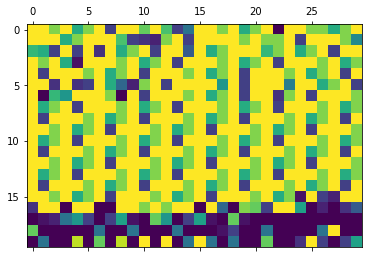

Fake Malware - WinWebSec


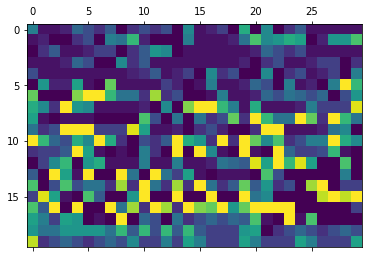

In [12]:
tmp = sequence.pad_sequences(X, maxlen=max_sequence_length, dtype='int32',
    padding='pre', truncating='pre', value=0.)

print('Real Malware - ' + real_malware)
plt.matshow(np.array(tmp[0]).reshape(20,30))
plt.show()

print('Fake Malware - ' + real_malware)
plt.matshow(np.array(tmp[5]).reshape(20,30))
plt.show()

Define Training and Test Datasets

In [13]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_sequence_length)

Define LSTM Model

In [14]:
# create LSTM model

if use_deep_classifiers:
    model = Sequential()
    model.add(Embedding(top_opcodes, embedding_vector_length, input_length=max_sequence_length))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=1)
    lstm_score = scores[1]*100
    print("LSTM Accuracy: %.2f%%" % (scores[1]*100))

    # Classification Report
    y_pred = np.round(model.predict(X_test))
    print(classification_report(y_test, y_pred, target_names=target_names))

Define Bidirectional LSTM Classifier

In [15]:
# create the bidirectional LSTM model

if use_deep_classifiers:
    model = Sequential()
    model.add(Embedding(top_opcodes, embedding_vector_length, input_length=max_sequence_length))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(X_train, y_train, epochs=10, batch_size=64)
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    bidirec_lstm_score = scores[1]*100
    print("Accuracy: %.2f%%" % (scores[1]*100))

    # Classification Report
    y_pred = np.round(model.predict(X_test))
    print(classification_report(y_test, y_pred, target_names=target_names))

Define CNN LSTM Classifier

In [16]:
# create the LSTM+CNN model

if use_deep_classifiers:
    model = Sequential()
    model.add(Embedding(top_opcodes, embedding_vector_length, input_length=max_sequence_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(X_train, y_train, epochs=10, batch_size=64)
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    cnn_lstm_score = scores[1]*100
    print("Accuracy: %.2f%%" % (scores[1]*100))

    # Classification Report
    y_pred = np.round(model.predict(X_test))
    print(classification_report(y_test, y_pred, target_names=target_names))

Define SVM Classifer

In [17]:
#Create a svm Classifier
model = svm.SVC(C=5,kernel='linear') # Linear Kernel

#Train the model using the training sets
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Final evaluation of the model
print("SVM Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
svm_score = accuracy_score(y_test, y_pred)*100

# Classification Report
y_pred = np.round(model.predict(X_test))
print(classification_report(y_test, y_pred, target_names=target_names)) 

SVM Accuracy: 98.22%
              precision    recall  f1-score   support

        Real       0.99      0.97      0.98      1463
        Fake       0.98      0.99      0.98      1626

    accuracy                           0.98      3089
   macro avg       0.98      0.98      0.98      3089
weighted avg       0.98      0.98      0.98      3089



Define Random Forest Classifier

In [18]:
#Create a Random Forest Classifier
model = RandomForestClassifier(max_depth=2, random_state=0)

#Train the model using the training sets
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Final evaluation of the model
print("Random Forest Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
rf_score = accuracy_score(y_test, y_pred)*100

# Classification Report
y_pred = np.round(model.predict(X_test))
print(classification_report(y_test, y_pred, target_names=target_names))

Random Forest Accuracy: 87.63%
              precision    recall  f1-score   support

        Real       1.00      0.74      0.85      1463
        Fake       0.81      1.00      0.89      1626

    accuracy                           0.88      3089
   macro avg       0.90      0.87      0.87      3089
weighted avg       0.90      0.88      0.87      3089



Define k-Nearest Neighbor Classifier

In [19]:
#Create a k-NN Classifier
model = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Final evaluation of the model
print("k-NN Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
knn_score = accuracy_score(y_test, y_pred)*100

# Classification Report
y_pred = np.round(model.predict(X_test))
print(classification_report(y_test, y_pred, target_names=target_names))

k-NN Accuracy: 95.69%
              precision    recall  f1-score   support

        Real       1.00      0.91      0.95      1463
        Fake       0.92      1.00      0.96      1626

    accuracy                           0.96      3089
   macro avg       0.96      0.95      0.96      3089
weighted avg       0.96      0.96      0.96      3089



Display All Classification Results

In [20]:
print('Classification on ' + str(nSamples) + ' ' + real_malware + ' Malware Samples (' + str(nRealSamples) + ' Real and ' + str(nFakeSamples) + ' Fake ' + select_malware + ')')
print('-------------------------------------------------')

print("SVM Score:", svm_score)
print("Random Forest Score:", rf_score)
print("k-Nearest Neighbor Score:", knn_score)

if use_deep_classifiers:
    print("Standard LSTM Score:", lstm_score)
    print("Bidirectional LSTM Score:", bidirec_lstm_score)
    print("CNN LSTM Score:", cnn_lstm_score)

    list_scores = [svm_score, rf_score, knn_score, lstm_score, bidirec_lstm_score, cnn_lstm_score]
else:
    list_scores = [svm_score, rf_score, knn_score]
print("=================================================")
print("Min Score:",min(list_scores))
print("Average Score:",sum(list_scores)/len(list_scores))
print("Max Score:",max(list_scores))
print("=================================================")

Classification on 9360 WinWebSec Malware Samples (4360 Real and 5000 Fake vae_cnn_samples)
-------------------------------------------------
SVM Score: 98.21948850760765
Random Forest Score: 87.63353836192942
k-Nearest Neighbor Score: 95.69439948203302
Min Score: 87.63353836192942
Average Score: 93.84914211719003
Max Score: 98.21948850760765


Classification using K-Folds

In [21]:

def support_vector_machine(X, y, real_malware, select_malware,target_names,max_sequence_length):
    print('******SVM******')
    k = 5
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = svm.SVC(C=5, kernel='rbf')
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\nK-Fold accuracy: ', accuracy)
    print('K-Fold precision: ', precision)
    print('K-Fold recall: ', recall)
    
    
    print('\nAvg K-Fold accuracy: %0.2f'%np.mean(np.array(accuracy)))
    print('Avg K-Fold precision: %0.2f'%np.mean(np.array(precision)))
    print('Avg K-Fold recall: %0.2f\n'%np.mean(np.array(recall)))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = svm.SVC(C=5, kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(4,4))
    plot_confusion_matrix(clf, X_test, y_test, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
    ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,select_malware))
    plt.show()
    
    print(classification_report(y_test, y_pred, target_names=target_names)) 

def naive_bayes(X, y, real_malware, select_malware,target_names,max_sequence_length):
    print('******Naive Bayes******')
    k = 5
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=6357)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = GaussianNB()
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\nK-Fold accuracy: ', accuracy)
    print('K-Fold precision: ', precision)
    print('K-Fold recall: ', recall)
    
    print('\nAvg K-Fold accuracy: %0.2f'%np.mean(np.array(accuracy)))
    print('Avg K-Fold precision: %0.2f'%np.mean(np.array(precision)))
    print('Avg K-Fold recall: %0.2f\n'%np.mean(np.array(recall)))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(4,4))
    plot_confusion_matrix(clf, X_test, y_test, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
    ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,select_malware))
    plt.show()
    
    print(classification_report(y_test, y_pred, target_names=target_names))

def random_forest(X, y, real_malware, select_malware,target_names,max_sequence_length):
    print('******Random Forest******')
    k = 5
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=6357)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(n_estimators=50, max_depth=5)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\nK-Fold accuracy: ', accuracy)
    print('K-Fold precision: ', precision)
    print('K-Fold recall: ', recall)
    
    print('\nAvg K-Fold accuracy: %0.2f'%np.mean(np.array(accuracy)))
    print('Avg K-Fold precision: %0.2f'%np.mean(np.array(precision)))
    print('Avg K-Fold recall: %0.2f\n'%np.mean(np.array(recall)))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = RandomForestClassifier(n_estimators=50, max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(4,4))
    plot_confusion_matrix(clf, X_test, y_test, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
    ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,select_malware))
    plt.show()
    
    print(classification_report(y_test, y_pred, target_names=target_names))

def k_nearest_neighbors(X, y, real_malware, select_malware,target_names,max_sequence_length):
    print('******K-Nearest Neighbors******')
    k = 5
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = KNeighborsClassifier(n_neighbors=6, p=2)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\nK-Fold accuracy: ', accuracy)
    print('K-Fold precision: ', precision)
    print('K-Fold recall: ', recall)
    
    print('\nAvg K-Fold accuracy: %0.2f'%np.mean(np.array(accuracy)))
    print('Avg K-Fold precision: %0.2f'%np.mean(np.array(precision)))
    print('Avg K-Fold recall: %0.2f\n'%np.mean(np.array(recall)))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = KNeighborsClassifier(n_neighbors=6, p=2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(4,4))
    plot_confusion_matrix(clf, X_test, y_test, display_labels=np.array(['real', 'fake']), cmap=plt.cm.Blues, ax=ax)
    ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,select_malware))
    plt.show()
    
    print(classification_report(y_test, y_pred, target_names=target_names))

******SVM******

K-Fold accuracy:  [1.0, 1.0, 1.0, 1.0, 1.0]
K-Fold precision:  [1.0, 1.0, 1.0, 1.0, 1.0]
K-Fold recall:  [1.0, 1.0, 1.0, 1.0, 1.0]

Avg K-Fold accuracy: 1.00
Avg K-Fold precision: 1.00
Avg K-Fold recall: 1.00



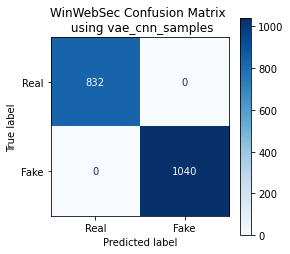

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00       832
        Fake       1.00      1.00      1.00      1040

    accuracy                           1.00      1872
   macro avg       1.00      1.00      1.00      1872
weighted avg       1.00      1.00      1.00      1872

******Naive Bayes******

K-Fold accuracy:  [0.8717948717948718, 0.7708333333333334, 0.8712606837606838, 0.8782051282051282, 0.7788461538461539]
K-Fold precision:  [0.9776674937965261, 0.7738209817131858, 0.9798234552332913, 0.9890243902439024, 0.7645348837209303]
K-Fold recall:  [0.7801980198019802, 0.8056112224448898, 0.7754491017964071, 0.7873786407766991, 0.821875]

Avg K-Fold accuracy: 0.83
Avg K-Fold precision: 0.90
Avg K-Fold recall: 0.79



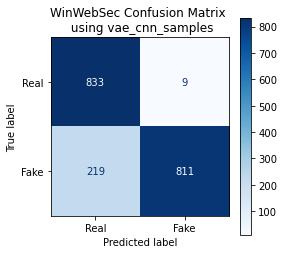

              precision    recall  f1-score   support

        Real       0.79      0.99      0.88       842
        Fake       0.99      0.79      0.88      1030

    accuracy                           0.88      1872
   macro avg       0.89      0.89      0.88      1872
weighted avg       0.90      0.88      0.88      1872

******Random Forest******

K-Fold accuracy:  [0.9903846153846154, 0.9957264957264957, 0.9935897435897436, 0.9946581196581197, 0.9914529914529915]
K-Fold precision:  [0.9834307992202729, 0.9920477137176938, 0.9881656804733728, 0.9903846153846154, 0.9845995893223819]
K-Fold recall:  [0.999009900990099, 1.0, 1.0, 1.0, 0.9989583333333333]

Avg K-Fold accuracy: 0.99
Avg K-Fold precision: 0.99
Avg K-Fold recall: 1.00



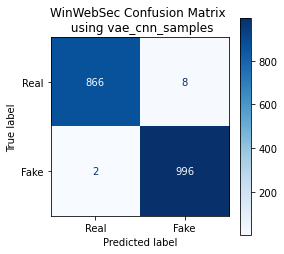

              precision    recall  f1-score   support

        Real       1.00      0.99      0.99       874
        Fake       0.99      1.00      1.00       998

    accuracy                           0.99      1872
   macro avg       0.99      0.99      0.99      1872
weighted avg       0.99      0.99      0.99      1872

******K-Nearest Neighbors******

K-Fold accuracy:  [0.9353632478632479, 0.9310897435897436, 0.9375, 0.9262820512820513, 0.9278846153846154]
K-Fold precision:  [0.894874022589053, 0.8876106194690265, 0.8933454876937101, 0.8775510204081632, 0.8819875776397516]
K-Fold recall:  [1.0, 0.9980099502487563, 1.0, 1.0, 0.9979919678714859]

Avg K-Fold accuracy: 0.93
Avg K-Fold precision: 0.89
Avg K-Fold recall: 1.00



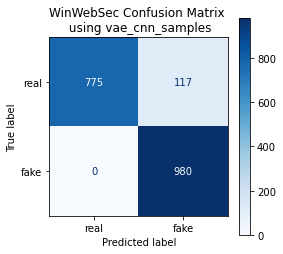

              precision    recall  f1-score   support

        Real       1.00      0.87      0.93       892
        Fake       0.89      1.00      0.94       980

    accuracy                           0.94      1872
   macro avg       0.95      0.93      0.94      1872
weighted avg       0.94      0.94      0.94      1872



In [22]:
support_vector_machine(X,y,real_malware,select_malware,target_names,max_sequence_length)
naive_bayes(X,y,real_malware,select_malware,target_names,max_sequence_length)
random_forest(X,y,real_malware,select_malware,target_names,max_sequence_length)
k_nearest_neighbors(X,y,real_malware,select_malware,target_names,max_sequence_length)